# Driving on a Mobius Strip

AutomotiveDrivingModels is templated to efficiently run different types of simulations.
Entities are parameterized by their:

- *S* state, which changes over time
- *D* defintion, which does not change over time
- *I* id, typically an `Int`, which uniquely identifies that entity.

In addition to these types, the actions, environment and the driver models can also be parameterized.

This notebook demonstrates a longitudinal driving simulation where cars drive on a single straight lane that loops back on itself.
The types are:

- *S* - `State1D`, containing the position and speed
- *D* - `VehicleDef`, containing length, width, and class
- *I* - `Int`

We use a `StraightRoadway` as our environment and `LaneFollowingDriver`s that produce `LaneFollowingAccel`s.


In [1]:
using AutomotiveDrivingModels
using AutoViz

INFO: Recompiling stale cache file /home/tim/.julia/lib/v0.5/AutomotiveDrivingModels.ji for module AutomotiveDrivingModels.


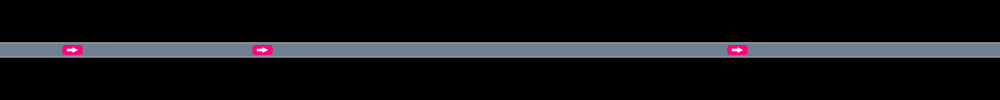

In [2]:
road_length = 200.0 # [meters]
roadway = StraightRoadway(road_length)

scene = MobiusScene()
push!(scene, Entity(State1D(10.0,  8.0), VehicleDef(), 1))
push!(scene, Entity(State1D(50.0, 12.5), VehicleDef(), 2))
push!(scene, Entity(State1D(150.0, 6.0), VehicleDef(), 3))

cam = StaticCamera(VecE2(100.0,0.0), 4.75)
render(scene, roadway, cam=cam, canvas_height=100)

We can add an overlay that displays the car id for convenience:

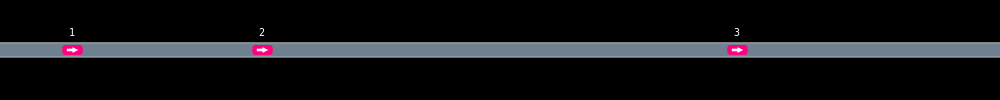

In [3]:
overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true, pos=VecE2(veh.state.s-0.7, 3)) for veh in scene]
render(scene, roadway, overlays, cam=cam, canvas_height=100)

Or we can create a new `SceneOverlay` which does this for us:

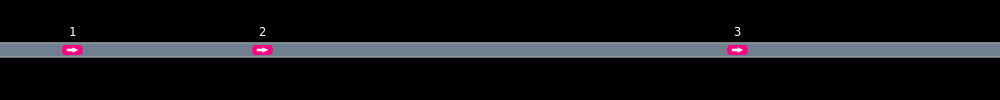

In [4]:
using Parameters
@with_kw type CarIDOverlay <: SceneOverlay
    textparams::TextParams=TextParams()
end
function AutoViz.render!(rendermodel::RenderModel, overlay::CarIDOverlay, scene::MobiusScene, roadway::StraightRoadway)
    for veh in scene
        x = veh.state.s - 0.7
        y = 3.0
        text = string(veh.id)
        add_instruction!(rendermodel, render_text, (text, x, y, overlay.textparams.size, overlay.textparams.color), incameraframe=true)
    end
    return rendermodel
end

render(scene, roadway, [CarIDOverlay()], cam=cam, canvas_height=100)

To run a simulation we need driving models that produce actions.
For this we will use `LaneFollowingDriver`s that produce `LaneFollowingAccel`s.
We will give each car a different model, as a demonstration.

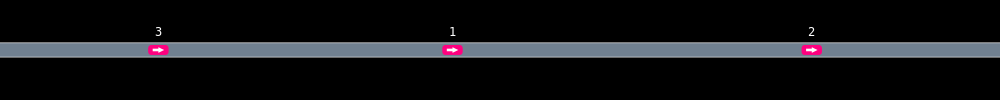

In [5]:
models = Dict{Int, LaneFollowingDriver}()
models[1] = StaticLaneFollowingDriver(0.0) # always produce zero acceleration
models[2] = IntelligentDriverModel(v_des=12.0) # default IDM with a desired speed of 12 m/s
models[3] = PrincetonDriver(v_des = 10.0) # default Princeton driver with a desired speed of 10m/s

nticks = 100
timestep = 0.1
rec = QueueRecord(MobiusVehicle, nticks+1, timestep)
simulate!(LaneFollowingAccel, rec, scene, roadway, models, nticks)
render(rec[0], roadway, [CarIDOverlay()], cam=cam, canvas_height=100)

We can use Interact to inspect the simulation.

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(50, nactions=1),"frame_index",50,"50",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(68=>"68",2=>"2",89=>"89",11=>"11",39=>"39",46=>"46",85=>"85",25=>"25",55=>"55",42=>"42"…)),Any[],Any[],true,"horizontal")

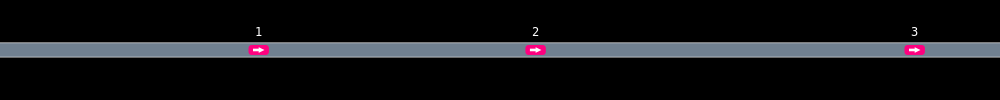

In [6]:
using Interact
@manipulate for frame_index in 1 : nframes(rec)
    render(rec[frame_index-nframes(rec)], roadway, [CarIDOverlay()], cam=cam, canvas_height=100)
end